In [25]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
from datetime import datetime

## Parameters

In [3]:
data_file = os.path.join(os.getcwd(), "CAISO_Data_2019_2021_NN.csv")
model_save_dir = os.path.join(os.getcwd(), "FF_models")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_out = 3    # 3 output parameters: MEF, MDF, interecept. 
             # inclusion of intercept is debatable (we'd love to have a model where it is zero),
             # and so far it has not much impacted r^2.
             # once we do test train split i only want to keep it if it notably improves model accuracy

In [4]:
device

device(type='cuda')

## data exploration

In [5]:
data_df = pd.read_csv(data_file)

In [6]:
data_df.head()

,Unnamed: 0,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE
0,2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,-98.530417,-29.956338
1,2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,-76.882199,-47.757034
2,2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,-61.425638,-69.432802
3,2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,-28.118595,-89.815150
4,2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,71.970840,-43.916667


## Data Loading and pre-processing

In [75]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

### Feature engineering...

## Temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
CAISO_Data.loc[:,"Hour"] = CAISO_Data.index.hour
# CAISO_Data.loc[:,"Is_Weekend"] = [instant.weekday() > 4 for instant in CAISO_Data.index]
# for day_of_week in range(7):
#     CAISO_Data.loc[:,f"Day_of_Week={day_of_week}"] = [instant.weekday() ==day_of_week for instant in CAISO_Data.index]

## Recent history features
# prev_time_steps = [1,2]#,24,3]
# for i in prev_time_steps:
#     CAISO_Data.loc[:,f"Load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Load"])
#     CAISO_Data.loc[:,f"VRE_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"VRE"])
#     # CAISO_Data.loc[:,f"d_emissions_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"delta_Total_CO2_Emissions"])
#     CAISO_Data.loc[:,f"Net_load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Net Load"])
# # Drop rows that don't have all prev-time-step features
# CAISO_Data = CAISO_Data.iloc[max(prev_time_steps):]


## load and VRE derivatives
# CAISO_Data.loc[:,"Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Load"].values - CAISO_Data.iloc[:-1].loc[:,"Load"].values)
# CAISO_Data.loc[:,"Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Load_d1"].values)
# CAISO_Data.loc[:,"VRE_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"VRE"].values - CAISO_Data.iloc[:-1].loc[:,"VRE"].values)
# CAISO_Data.loc[:,"VRE_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"VRE_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"VRE_d1"].values)
CAISO_Data.loc[:,"Net_Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Net Load"].values - CAISO_Data.iloc[:-1].loc[:,"Net Load"].values)
# CAISO_Data.loc[:,"Net_Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Net_Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Net_Load_d1"].values)
# # Drop rows that don't have all features
CAISO_Data = CAISO_Data.iloc[1:]


num_samples = len(CAISO_Data)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

## old features we've tried
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
# feature_cols.extend([f"Load_t-{i}" for i in prev_time_steps] + [f"VRE_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Load_d1", "Load_d2", "VRE_d1", "VRE_d2"])
# feature_cols.extend(["delta_Load", "delta_VRE"])
# feature_cols.extend([f"d_emissions_t-{i}" for i in prev_time_steps])
# feature_cols.extend([f"Net_load_t-{i}" for i in prev_time_steps])
feature_cols.extend(["Net_Load_d1"])

# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))
# train_y = torch.tensor(np.array(CAISO_train['delta_Total_CO2_Emissions'].values).astype(np.float32))
# val_y = torch.tensor(np.array(CAISO_val['delta_Total_CO2_Emissions'].values).astype(np.float32))
# test_y = torch.tensor(np.array(CAISO_test['delta_Total_CO2_Emissions'].values).astype(np.float32))


# standardize data based on mean and variance of train data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x)
train_x = torch.tensor(scaler.transform(train_x)).to(device)
val_x = torch.tensor(scaler.transform(val_x)).to(device)
test_x = torch.tensor(scaler.transform(test_x)).to(device)

In [76]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,delta_Total_NOX_Emissions,delta_VRE,Day_of_Year,Hour,Net_Load_d1
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,-76.882199,-47.757034,1,1,-895.521594
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,-61.425638,-69.432802,1,2,-550.569271
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,-28.118595,-89.815150,1,3,-184.849036
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,71.970840,-43.916667,1,4,-858.751934
2019-01-01 05:00:00,20788.250000,18657.333333,5.121183e+06,683.373182,2463.943924,2130.916667,461.166667,644.666667,88759.691104,-28.538786,72.286054,-183.750000,1,5,644.666667


In [77]:
train_x.shape

torch.Size([15782, 5])

In [78]:
feature_cols

['Load', 'VRE', 'Hour', 'Day_of_Year', 'Net_Load_d1']

## define model and set params

In [79]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

# Stepp: gotta start with tensors and use torch math functions to keep as tensors
# def mse_loss(pred_coeff, CAISO_Data):
#     delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
#     delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
#     MEF_preds = pred_coeff[:,0]
#     MDF_preds = pred_coeff[:,1]
#     pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
#     pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
#     pred_y = torch.add(pred_y_vre, pred_y_demand)
#     act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))
#     loss = nn.MSELoss()(pred_y, act_y)
#     return loss

def mse_loss_regularized_preds_l2(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF^2 + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 4420  # based on an average value of -65 seen amongst invalids when trained without regularization
    MEF_reg = torch.dot(invalid_MEFs, invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF^2 + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 538  # based on an average value of +23 seen amongst invalids when trained without regularization
    MDF_reg = torch.dot(invalid_MDFs, invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

def mse_loss_regularized_preds_l1(pred_coeff, CAISO_Data, MEF_reg_weight, MDF_reg_weight, bias_term):
    delta_load_tensor = torch.tensor(np.array(CAISO_Data['delta_Load'].values).astype(np.float32))
    delta_vre_tensor = torch.tensor(np.array(CAISO_Data['delta_VRE'].values).astype(np.float32))
    MEF_preds = pred_coeff[:,0]
    MDF_preds = pred_coeff[:,1]
    pred_y_demand = torch.mul(delta_load_tensor, MEF_preds)
    pred_y_vre = torch.mul(delta_vre_tensor, MDF_preds)
    pred_y = pred_y_vre + pred_y_demand
    if bias_term:
        bias_preds = pred_coeff[:,2]
        pred_y += bias_preds
    act_y = torch.tensor(np.array(CAISO_Data['delta_Total_CO2_Emissions'].values).astype(np.float32))

    # Compute MEF regularization term (sum(MEF + intercept if MEF < 0 for MEF in examples))
    invalid_MEFs = nn.functional.relu(-MEF_preds)  # keep negative MEFs and zero others
    count_invalid_MEFs = torch.count_nonzero(invalid_MEFs)
    MEF_reg_intercept = 66.5  # The average value seen amongst invalids when trained without regularization
    MEF_reg = torch.sum(invalid_MEFs) + (count_invalid_MEFs * MEF_reg_intercept)

    # Compute MDF regularization term (sum(MDF + intercept if MDF > 0 for MDF in examples))
    invalid_MDFs = nn.functional.relu(MDF_preds)  # keep negative MEFs and zero others
    count_invalid_MDFs = torch.count_nonzero(invalid_MDFs)
    MDF_reg_intercept = 23.2  # The average value seen amongst invalids when trained without regularization
    MDF_reg = torch.sum(invalid_MDFs) + (count_invalid_MDFs * MDF_reg_intercept)

    loss = nn.MSELoss()(pred_y, act_y) + (MEF_reg_weight * MEF_reg) + (MDF_reg_weight * MDF_reg)
    return loss

## Model Training

Helpers for printing results

In [80]:
pd.options.mode.chained_assignment = None  # default='warn'

In [81]:
def plot_losses(train_losses, val_losses, plt_save_dir=None):
    #plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[1000:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[1000:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(os.path.join(plt_save_dir,"train_val_losses.png"))

#     # count number of invalid values predicted
#     invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
#     invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)

#     #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
#     coeff_df=pd.DataFrame(data=train_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
#     train_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
#     train_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
#     if bias_term:
#         train_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

#     #calculate some error stuff. rn i am thinking R2 is the best measure of error
#     d_emissions = train_CAISO_Data.loc[:,'MEF'] * train_CAISO_Data.loc[:,'delta_Load'] \
#                 + train_CAISO_Data.loc[:,'MDF'] * train_CAISO_Data.loc[:,'delta_VRE']
#     if bias_term:
#         d_emissions += train_CAISO_Data.loc[:,'Intercept'] 
#     train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
#     train_CAISO_Data.loc[:,'Error']=train_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
#     train_CAISO_Data.loc[:,'%_Error']=np.abs(train_CAISO_Data.loc[:,'Error'])/np.abs(train_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
#     print("Train Set:")
#     print(f"\tMean Emissions Change = {np.mean(np.abs(train_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
#     print(f"\tMean Error = {np.mean(np.abs(train_CAISO_Data['Error'])):.2f}")
#     print(f"\tInvalid MEFs,MDFs = {invalid_train_MEFs},{invalid_train_MDFs}")
#     print(f"\tR Squared = {r2_score(train_CAISO_Data['delta_Total_CO2_Emissions'],train_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
#     #TODO make this better so we don't have copy pasta
#     #add MEF, MDF and interecept results to orignial frame #TODO once again seems like more operations than necessary
#     coeff_df=pd.DataFrame(data=val_pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
#     val_CAISO_Data.loc[:,'MEF']=coeff_df.loc[:,'MEF'].values
#     val_CAISO_Data.loc[:,'MDF']=coeff_df.loc[:,'MDF'].values
#     if bias_term:
#         val_CAISO_Data.loc[:,'Intercept']=coeff_df.loc[:,'Intercept'].values

#     #calculate some error stuff. rn i am thinking R2 is the best measure of error
#     d_emissions = val_CAISO_Data.loc[:,'MEF'] * val_CAISO_Data.loc[:,'delta_Load'] \
#                 + val_CAISO_Data.loc[:,'MDF']*val_CAISO_Data.loc[:,'delta_VRE']
#     if bias_term:
#         d_emissions += val_CAISO_Data.loc[:,'Intercept'] 
#     val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
#     val_CAISO_Data.loc[:,'Error']=val_CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
#     val_CAISO_Data.loc[:,'%_Error']=np.abs(val_CAISO_Data.loc[:,'Error'])/np.abs(val_CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
#     print("Val Set:")
#     print(f"\tMean Emissions Change = {np.mean(np.abs(val_CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
#     print(f"\tMean Error = {np.mean(np.abs(val_CAISO_Data['Error'])):.2f}")
#     print(f"\tInvalid MEFs,MDFs = {invalid_val_MEFs},{invalid_val_MDFs}")
#     print(f"\tR Squared = {r2_score(val_CAISO_Data['delta_Total_CO2_Emissions'],val_CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
    
def get_r_squared(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    r2 = r2_score(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return r2

def get_mean_abs_err(pred_coeff, CAISO_Data, bias_term):
    coeff_df=pd.DataFrame(data=pred_coeff.detach().numpy(), columns=['MEF', 'MDF', 'Intercept'])
    pred_delta_total_co2_emissions = coeff_df['MEF'].values * CAISO_Data['delta_Load'] \
                                   + coeff_df['MDF'].values * CAISO_Data['delta_VRE']
    if bias_term:
        pred_delta_total_co2_emissions += coeff_df['Intercept'].values
    mean_abs_err = mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], pred_delta_total_co2_emissions)
    return mean_abs_err

def get_count_invalid_preds(pred_coeff):
    # preds=pred_coeff.detach().numpy()
    count_neg_MEFs = torch.sum(pred_coeff[:,0] <= 0).item() #sum(preds[:,0] <= 0) # MEF must be greater than 0
    count_pos_MDFs = torch.sum(pred_coeff[:,1] > 0).item() #sum(preds[:,1] > 0)  # MDF must be less than or equal to 0
    return count_neg_MEFs, count_pos_MDFs

Train the model

In [82]:
def train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, learning_rate, weight_decay, dropout_p, \
                            loss_function, MEF_reg_weight, MDF_reg_weight, bias_term, model_dir_prefix=None, epochs=10000, min_save_r2=.87):
    
    n_input = train_x.shape[1]
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir = os.path.join(model_dir, model_dir_prefix)
    model_dir = os.path.join(model_dir, str(datetime.now().strftime('%Y_%m_%d-%I_%M_%S_%p')))
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    
    # log experiment settings
    settings_str = "Model Settings:"
    settings_str += f"\n\t{n_input=}\n\t{hidden_dims=}\n\t{n_out=}\n\t{dropout_p=}\n\t{bias_term=}"
    settings_str += "\nOptimizer Settings:"
    settings_str += f"\n\t{learning_rate=}\n\t{weight_decay=}"
    settings_str += "\nLoss Function Settings:"
    settings_str += f"\n\t{loss_function=}\n\t{MEF_reg_weight=}\n\t{MDF_reg_weight=}"
    settings_str += "\nTrain Process Settings:"
    settings_str += f"\n\t{epochs=}\n\t{min_save_r2=}"
    settings_str += f"\nFeatures: {', '.join(feature_cols)}"
    print(settings_str)
    with open(os.path.join(model_dir, "experiment_settings.txt"), 'w+') as f:
        f.write(settings_str)
        
    model.to(device)

    best_r2 = -np.inf 
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    last_save_r2 = -np.inf
    last_save_mae = np.inf
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_pred_coeff=model(train_x.float()).cpu()
        train_loss=loss_function(train_pred_coeff, CAISO_train, MEF_reg_weight, MDF_reg_weight, bias_term)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_pred_coeff=model(val_x.float()).cpu()
        val_loss=loss_function(val_pred_coeff, CAISO_val, MEF_reg_weight, MDF_reg_weight, bias_term)
        val_losses.append(val_loss.item())
        val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_epoch = epoch
        # check if we should save... we need good enough r2 and no invalids
        if val_r2 > max(last_save_r2, min_save_r2):
            if sum(get_count_invalid_preds(val_pred_coeff))==0:
                # also check training invalids... Let's recompute with eval mode
                model.eval()
                eval_mode_train_preds=model(train_x.float()).cpu()
                if sum(get_count_invalid_preds(eval_mode_train_preds))==0:
                    if save_model_path:
                        Path(save_model_path).unlink() # delete prev-best model
                    model_save_name = f"epoch={epoch},r2={val_r2:.4f},Invalids=0.pth"
                    save_model_path = os.path.join(model_dir, model_save_name)
                    torch.save(model.state_dict(), save_model_path)
                    last_save_epoch = epoch
                    last_save_r2 = val_r2
                    last_save_mae = get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term)

        
        if epoch % 1000 == 0:
            invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
            invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
            train_r2 = get_r_squared(train_pred_coeff, CAISO_train, bias_term)
            # val_r2 = get_r_squared(val_pred_coeff, CAISO_val, bias_term)
            print(f"[Epoch {epoch}]")
            print(f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}, Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
            print(f"\tVal Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}, Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break
        
    plot_losses(train_losses, val_losses, model_dir)

    results_str = f"Best R Squared seen on epoch {best_epoch}: {best_r2:.4f}"
    results_str += f"\nBest-R2-model with R2 above {min_save_r2=} and 0 invalid coefficients predicted on train/test sets:"
    if not save_model_path:
        results_str += f"\n\tNo such model was encountered"
    else:
        results_str += f"\n\tValidation R2: {last_save_r2:.4f}"
        results_str += f"\n\tValidation MAE: {last_save_mae:.2f}"
        results_str += f"\n\tEpoch seen: {last_save_epoch}"
        results_str += f"\n\tModel file: {save_model_path.split('/')[-1]}"

    print(results_str)
    with open(os.path.join(model_dir, "results.txt"), 'w+') as f:
        f.write(results_str)
        
    return save_model_path

### Train with varying hyperparams

Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.001
	weight_decay=0.01
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.225e+12, R Squared=-0.0008, Invalid MEFs=11454, Invalid MDFs=6395
	Val Set: Loss=6.723e+11, R Squared=-0.0007, Invalid MEFs=4503, Invalid MDFs=2802
[Epoch 1000]
	Train Set: Loss=5.299e+10, R Squared=0.8268, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.999e+10, R Squared=0.8372, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.355e+10, R Squared=0.8576, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.146e+10, R Squared=0.8649, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.176e+10, R Squared=0.8635, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.038e+10, R Squared=0.8685, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.079e+10, R Squared=0.8667, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.971e+10, R Squared=0.8707, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.046e+10, R Squared=0.8677, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.926e+10, R Squared=0.8721, Invalid MEFs=0, Invalid MDFs=

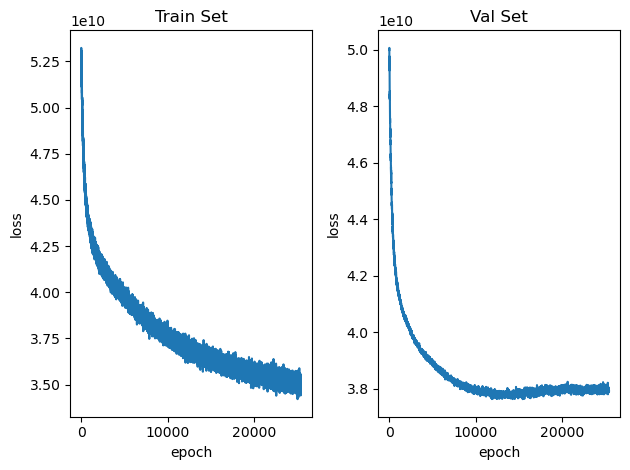

Best R Squared seen on epoch 16453: 0.8774
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8774
	Validation MAE: 138925.21
	Epoch seen: 16453
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_11_20_PM\epoch=16453,r2=0.8774,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.001
	weight_decay=0.03
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=8.893e+11, R Squared=0.0014, Invalid MEFs=7584, Invalid MDFs=3258
	Val Set: Loss=3.899e+11, R Squared=0.0003, Invalid MEFs=1220, Invalid MDFs=77
[Epoch 1000]
	Train Set: Loss=5.260e+10, R Squared=0.8281, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.940e+10, R Squared=0.8391, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.401e+10, R Squared=0.8561, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.199e+10, R Squared=0.8632, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.190e+10, R Squared=0.8630, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.049e+10, R Squared=0.8681, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.117e+10, R Squared=0.8654, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.972e+10, R Squared=0.8706, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.021e+10, R Squared=0.8686, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.930e+10, R Squared=0.8720, Invalid MEFs=0, Invalid MDFs=0
[Ep

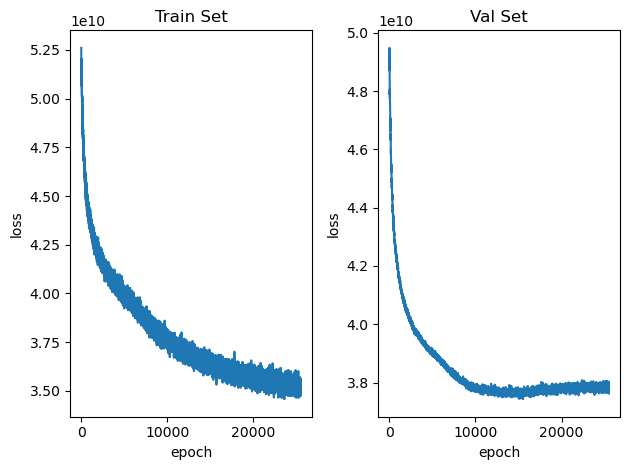

Best R Squared seen on epoch 16518: 0.8781
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8781
	Validation MAE: 138487.98
	Epoch seen: 16518
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_15_56_PM\epoch=16518,r2=0.8781,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.001
	weight_decay=0.1
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=6.815e+11, R Squared=0.0014, Invalid MEFs=3714, Invalid MDFs=5435
	Val Set: Loss=3.415e+11, R Squared=-0.0000, Invalid MEFs=285, Invalid MDFs=668
[Epoch 1000]
	Train Set: Loss=5.333e+10, R Squared=0.8257, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=5.047e+10, R Squared=0.8356, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.429e+10, R Squared=0.8552, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.234e+10, R Squared=0.8621, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.196e+10, R Squared=0.8628, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.074e+10, R Squared=0.8673, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=4.133e+10, R Squared=0.8649, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.012e+10, R Squared=0.8693, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.085e+10, R Squared=0.8665, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.957e+10, R Squared=0.8711, Invalid MEFs=0, Invalid MDFs=0
[E

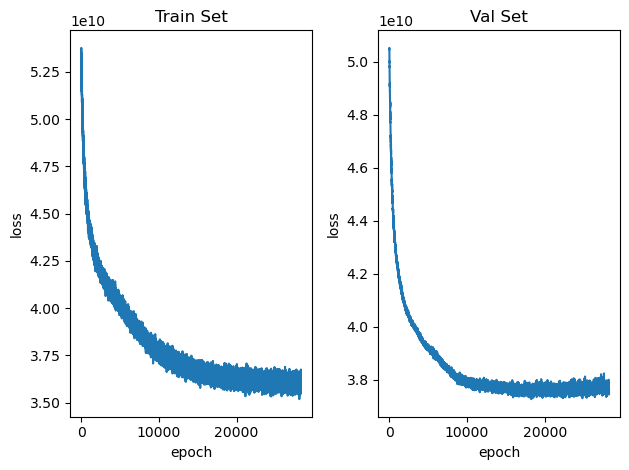

Best R Squared seen on epoch 19275: 0.8786
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8786
	Validation MAE: 138429.90
	Epoch seen: 19275
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_20_33_PM\epoch=19275,r2=0.8786,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.003
	weight_decay=0.01
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.133e+12, R Squared=-0.0002, Invalid MEFs=10032, Invalid MDFs=6572
	Val Set: Loss=6.018e+11, R Squared=-0.0006, Invalid MEFs=3203, Invalid MDFs=3500
[Epoch 1000]
	Train Set: Loss=4.232e+10, R Squared=0.8617, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.094e+10, R Squared=0.8667, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.082e+10, R Squared=0.8666, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.951e+10, R Squared=0.8713, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.986e+10, R Squared=0.8697, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.887e+10, R Squared=0.8734, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.878e+10, R Squared=0.8732, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.824e+10, R Squared=0.8754, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.755e+10, R Squared=0.8773, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.797e+10, R Squared=0.8763, Invalid MEFs=0, Invalid MDFs=

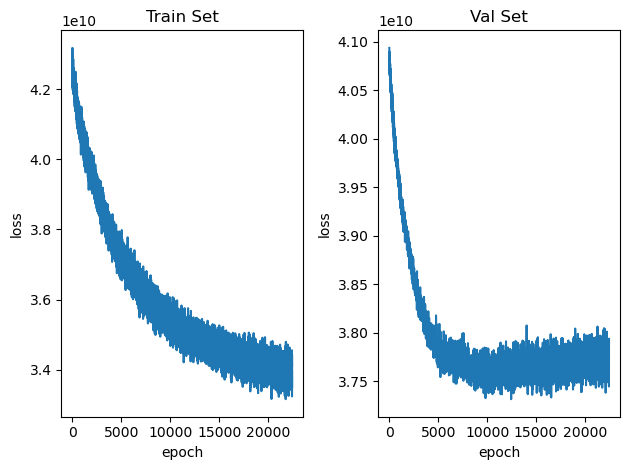

Best R Squared seen on epoch 13453: 0.8784
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8784
	Validation MAE: 138343.94
	Epoch seen: 13453
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_25_36_PM\epoch=13453,r2=0.8784,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.003
	weight_decay=0.03
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.031e+12, R Squared=-0.0006, Invalid MEFs=8004, Invalid MDFs=8030
	Val Set: Loss=6.670e+11, R Squared=-0.0005, Invalid MEFs=5212, Invalid MDFs=548
[Epoch 1000]
	Train Set: Loss=4.267e+10, R Squared=0.8605, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.097e+10, R Squared=0.8665, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.061e+10, R Squared=0.8672, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.948e+10, R Squared=0.8714, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.943e+10, R Squared=0.8711, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.883e+10, R Squared=0.8735, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.900e+10, R Squared=0.8725, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.838e+10, R Squared=0.8750, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.851e+10, R Squared=0.8745, Invalid MEFs=1, Invalid MDFs=1
	Val Set: Loss=3.802e+10, R Squared=0.8761, Invalid MEFs=0, Invalid MDFs=0


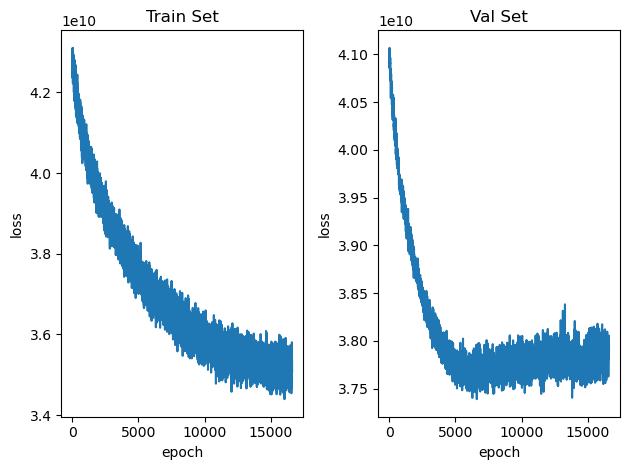

Best R Squared seen on epoch 7615: 0.8782
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8782
	Validation MAE: 138232.95
	Epoch seen: 7615
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_29_38_PM\epoch=7615,r2=0.8782,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.003
	weight_decay=0.1
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.067e+12, R Squared=-0.0010, Invalid MEFs=7748, Invalid MDFs=10231
	Val Set: Loss=6.246e+11, R Squared=-0.0008, Invalid MEFs=3115, Invalid MDFs=4717
[Epoch 1000]
	Train Set: Loss=4.303e+10, R Squared=0.8594, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=4.139e+10, R Squared=0.8652, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=4.116e+10, R Squared=0.8655, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.998e+10, R Squared=0.8698, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.017e+10, R Squared=0.8687, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.944e+10, R Squared=0.8715, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.954e+10, R Squared=0.8707, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.870e+10, R Squared=0.8739, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.897e+10, R Squared=0.8726, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.835e+10, R Squared=0.8751, Invalid MEFs=0, Invalid MDFs=

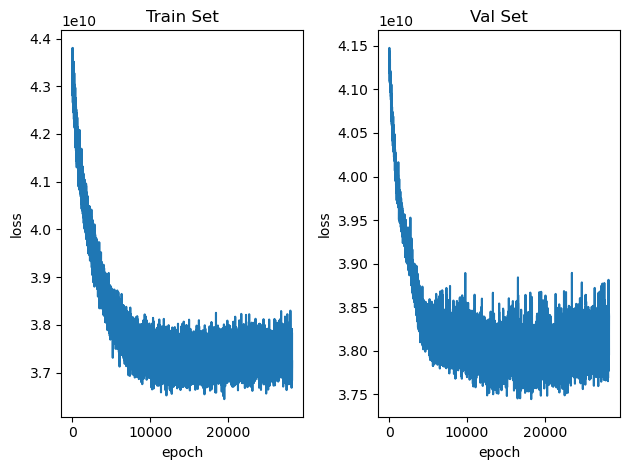

Best R Squared seen on epoch 19238: 0.8780
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8780
	Validation MAE: 138382.00
	Epoch seen: 19238
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_32_39_PM\epoch=19238,r2=0.8780,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.01
	weight_decay=0.01
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=9.562e+11, R Squared=-0.0001, Invalid MEFs=5966, Invalid MDFs=10623
	Val Set: Loss=5.075e+11, R Squared=0.0002, Invalid MEFs=2725, Invalid MDFs=825
[Epoch 1000]
	Train Set: Loss=4.058e+10, R Squared=0.8674, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.938e+10, R Squared=0.8717, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.869e+10, R Squared=0.8735, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.840e+10, R Squared=0.8749, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.796e+10, R Squared=0.8762, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.803e+10, R Squared=0.8761, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.730e+10, R Squared=0.8783, Invalid MEFs=1, Invalid MDFs=0
	Val Set: Loss=3.784e+10, R Squared=0.8767, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.645e+10, R Squared=0.8809, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.786e+10, R Squared=0.8767, Invalid MEFs=0, Invalid MDFs=0


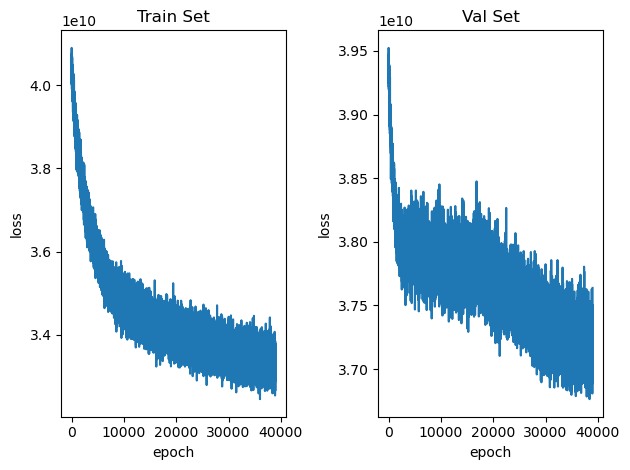

Best R Squared seen on epoch 39414: 0.8802
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8802
	Validation MAE: 136662.70
	Epoch seen: 39414
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_37_37_PM\epoch=39414,r2=0.8802,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.01
	weight_decay=0.03
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=1.507e+12, R Squared=-0.0041, Invalid MEFs=13548, Invalid MDFs=12141
	Val Set: Loss=7.823e+11, R Squared=-0.0023, Invalid MEFs=5260, Invalid MDFs=5260
[Epoch 1000]
	Train Set: Loss=4.072e+10, R Squared=0.8669, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.971e+10, R Squared=0.8706, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.906e+10, R Squared=0.8723, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.871e+10, R Squared=0.8739, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=3.806e+10, R Squared=0.8756, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.835e+10, R Squared=0.8751, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.736e+10, R Squared=0.8779, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.806e+10, R Squared=0.8760, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=3.758e+10, R Squared=0.8776, Invalid MEFs=2, Invalid MDFs=0
	Val Set: Loss=3.786e+10, R Squared=0.8767, Invalid MEFs=0, Invalid MDFs

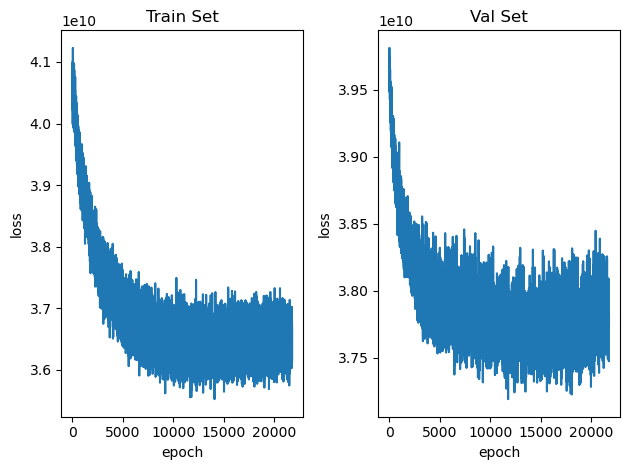

Best R Squared seen on epoch 12772: 0.8789
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8789
	Validation MAE: 137962.64
	Epoch seen: 12772
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_44_26_PM\epoch=12772,r2=0.8789,Invalids=0.pth
Model Settings:
	n_input=5
	hidden_dims=[512, 256]
	n_out=3
	dropout_p=0.5
	bias_term=True
Optimizer Settings:
	learning_rate=0.01
	weight_decay=0.1
Loss Function Settings:
	loss_function=<function mse_loss_regularized_preds_l1 at 0x000001262BCB4790>
	MEF_reg_weight=1000000.0
	MDF_reg_weight=1000000.0
Train Process Settings:
	epochs=40000
	min_save_r2=0.87
Features: Load, VRE, Hour, Day_of_Year, Net_Load_d1


  0%|          | 0/40000 [00:00<?, ?it/s]

[Epoch 0]
	Train Set: Loss=9.147e+11, R Squared=0.0008, Invalid MEFs=7136, Invalid MDFs=5593
	Val Set: Loss=6.043e+11, R Squared=-0.0001, Invalid MEFs=4389, Invalid MDFs=214
[Epoch 1000]
	Train Set: Loss=4.114e+10, R Squared=0.8655, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.988e+10, R Squared=0.8701, Invalid MEFs=0, Invalid MDFs=0
[Epoch 2000]
	Train Set: Loss=3.999e+10, R Squared=0.8694, Invalid MEFs=0, Invalid MDFs=1
	Val Set: Loss=3.954e+10, R Squared=0.8712, Invalid MEFs=0, Invalid MDFs=0
[Epoch 3000]
	Train Set: Loss=4.008e+10, R Squared=0.8690, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.887e+10, R Squared=0.8734, Invalid MEFs=0, Invalid MDFs=0
[Epoch 4000]
	Train Set: Loss=3.974e+10, R Squared=0.8701, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.893e+10, R Squared=0.8732, Invalid MEFs=0, Invalid MDFs=0
[Epoch 5000]
	Train Set: Loss=4.001e+10, R Squared=0.8692, Invalid MEFs=0, Invalid MDFs=0
	Val Set: Loss=3.898e+10, R Squared=0.8730, Invalid MEFs=0, Invalid MDFs=0
[

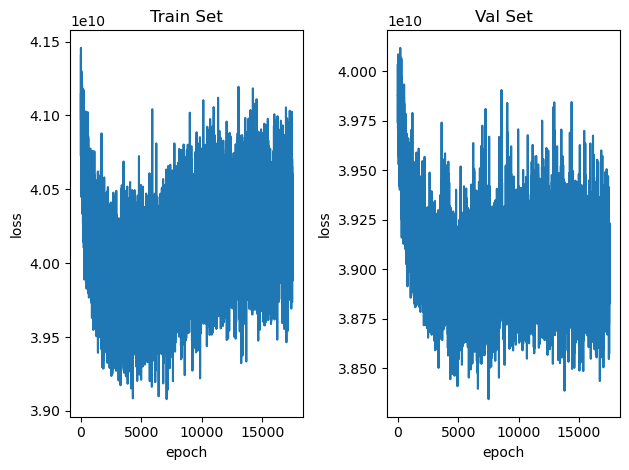

Best R Squared seen on epoch 8511: 0.8751
Best-R2-model with R2 above min_save_r2=0.87 and 0 invalid coefficients predicted on train/test sets:
	Validation R2: 0.8751
	Validation MAE: 139953.93
	Epoch seen: 8511
	Model file: C:\Users\nicklein\Documents\MEF-Regression\FF_models\net_load_d1\2023_01_10-07_48_19_PM\epoch=8511,r2=0.8751,Invalids=0.pth


In [83]:
hidden_dim_settings = [[512,256]]
lrs = [.001, .003, .01]
weight_decays = [.01, .03, .1]
dropout_probs = [0.5]
bias_term = True
regularization_weights = [[1e6,1e6]]
loss_function = mse_loss_regularized_preds_l1
save_prefix = "net_load_d1"

for hidden_dims in hidden_dim_settings:
    for lr in lrs:
        for weight_decay in weight_decays:
            for dropout_p in dropout_probs:
                for reg_weights in regularization_weights:
                    train_model_with_params(train_x, val_x, CAISO_train, CAISO_val, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                            loss_function, *reg_weights, bias_term, save_prefix, epochs=40000, min_save_r2=.87)

## Inference on all data

In [47]:
## below we can load specific models instead of best one found in most recent experiment
best_model_dir = os.path.join(model_save_dir, "base4_features\\2023_01_10-05_36_38_PM")
best_model_file = os.path.join(best_model_dir, "epoch=37502,r2=0.8856,Invalids=0.pth")


In [48]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]

model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_file))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

print("R Squared:")
print(f"\tTrain: {get_r_squared(train_pred_coeff, CAISO_train, bias_term):.4f}")
print(f"\tVal: {get_r_squared(val_pred_coeff, CAISO_val, bias_term):.4f}")
print(f"\tTest: {get_r_squared(test_pred_coeff, CAISO_test, bias_term):.4f}")
print("Mean Absolute Error:")
print(f"\tTrain: {get_mean_abs_err(train_pred_coeff, CAISO_train, bias_term):.2f}")
print(f"\tVal: {get_mean_abs_err(val_pred_coeff, CAISO_val, bias_term):.2f}")
print(f"\tTest: {get_mean_abs_err(test_pred_coeff, CAISO_test, bias_term):.2f}")
print("Count Invalid Values Predicted:")
invalid_train_MEFs, invalid_train_MDFs = get_count_invalid_preds(train_pred_coeff)
invalid_val_MEFs, invalid_val_MDFs = get_count_invalid_preds(val_pred_coeff)
invalid_test_MEFs, invalid_test_MDFs = get_count_invalid_preds(test_pred_coeff)
print(f"\tTrain: Invalid MEFs={invalid_train_MEFs}, Invalid MDFs={invalid_train_MDFs}")
print(f"\tVal: Invalid MEFs={invalid_val_MEFs}, Invalid MDFs={invalid_val_MDFs}")
print(f"\tTest: Invalid MEFs={invalid_test_MEFs}, Invalid MDFs={invalid_test_MDFs}")


R Squared:
	Train: 0.8952
	Val: 0.8856
	Test: 0.8845
Mean Absolute Error:
	Train: 128716.47
	Val: 135255.84
	Test: 136301.10
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [49]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [50]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [51]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413039.90
	R Squared = 0.8911
	Mean Absolute Error = 131541.45


In [52]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Net_load_t-2,Load_t-24,VRE_t-24,Net_load_t-24,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-02 00:00:00,21302.833333,21101.416667,5.943198e+06,706.598543,2809.132307,201.416667,-996.500000,-949.583333,-514537.672003,-28.866116,...,23586.083333,22822.964472,2320.593616,20502.358502,283.953339,-228.285400,-5145.945312,-277414.080999,237123.591004,0.460848
2019-01-02 01:00:00,20601.750000,20386.750000,5.390742e+06,614.071061,2441.373928,214.833333,-701.083333,-714.666667,-552455.804690,-92.527482,...,22051.000000,21879.620618,2272.780097,19606.836908,300.851196,-247.100433,-4838.494141,-219075.517820,333380.286870,0.603452
2019-01-02 02:00:00,20271.416667,20002.833333,5.601578e+06,532.972949,2352.518468,268.666667,-330.333333,-383.916667,210835.582471,-81.098112,...,21101.416667,21257.454020,2201.182455,19056.267637,300.390656,-243.878098,-5239.135254,-117596.952710,-328432.535181,1.557766
2019-01-02 03:00:00,20383.416667,20090.916667,5.677326e+06,563.077187,2584.969715,292.333333,112.000000,88.083333,75748.112826,30.104238,...,20386.750000,20974.800758,2103.388502,18871.418601,296.729248,-240.134262,-5615.921387,21934.576859,-53813.535968,0.710427
2019-01-02 04:00:00,21148.166667,20833.000000,6.015296e+06,719.733904,2973.857829,315.166667,764.750000,742.083333,337969.564672,156.656716,...,20002.833333,20327.083333,2314.666667,18012.666667,291.271790,-240.853806,-5367.077637,211883.528196,-126086.036477,0.373069


In [53]:
CAISO_Data.to_csv(os.path.join(best_model_dir, "CAISO_Data_2019_2021_NN.with_coeff_preds.csv"))

In [54]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [55]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

0

In [56]:
CAISO_Data.loc[:,"MEF"].max()

569.45947265625